In [1]:
# %load Initialization
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: Some parameters and inputs are initialized here

import numpy as np

## Meal Input
# meal time
tk_list  = [60, 350, 720]      #unit: min
# meal intake value
qk_list  = [3000, 4500, 3500]  #unit: mg/min, from ref 1 in Xinyu's writeup
# digestion coefficient
tau      = 100                 #unit: 1  [unknown parameter!!!]
# initial glucose rate of appearance
Ra_0     = 5                   #unit: mg/kg/min

## Insulin Parameter
c1       = 0.25                #unit: min^-1   [unknown parameter!!!]
c2       = 0.2                 #unit: min^-1   [unknown parameter!!!]
I0       = 0.38                #unit: mU/l     [unknown initial condition]
Ib       = 0

## Minimal Model Parameter
p1       = 0.6                 #param determined by bio-experiments (unit: min^-1)
p2       = 0.0122              #unit: min^-1
p3       = 1.7e-5              #unit: min^-2 mU/l
Gb       = 125                 #basal plasma glucose (unit:mg/dl)
G0       = 130
X0       = 0
"""A fasting blood sugar level less than 100 mg/dL (5.6 mmol/L) is normal.
 A fasting blood sugar level from 100 to 125 mg/dL (5.6 to 6.9 mmol/L) is considered prediabetes.
  If it's 126 mg/dL (7 mmol/L) or higher on two separate tests, you have diabete"""

## Cost function parameter
lam      = 0.5

## Code Parameter
end_time = 1000                 #unit: min
N        = int(end_time*2+1)    #num of time step
t_list   = np.linspace(0, end_time, N)
h        = t_list[1]-t_list[0]
dt       = 5                    #unit: min
N_meas   = int(end_time/dt+1)   #num of measurements
meas_time= np.linspace(0, end_time, N_meas)



In [2]:
# %load Linear_approx
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: Some tools to determine function value based on linear approximation has been included here
import numpy as np

def Linear_func(t, I_list, t_list):
    """ Find out I at time t using a linear approximation between two points in t_list
    @:param t:         given time
    @:param I_list:    a list of function values with respect to t
    @:param t_list:    the corresponding time discretization """


    idx1 = np.searchsorted(t_list, t, side="right") # t_list[idx1]<= t < t_list[idx2]
    idx2 = idx1+1

    if idx2<len(I_list):
        y1   = I_list[idx1]
        y2   = I_list[idx2]
        x1   = t_list[idx1]
        x2   = t_list[idx2]
        I_t  = (y2-y1)/(x2-x1)*(t-x1)+y1
        return I_t
    return I_list[-1]


In [3]:
# %load Glucose
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: This program contains parameters and functions to determine Glucose function theoretically

import numpy as np

def u(t, tk):
    """a step function u: u(t) = 0 if t<=tk, u(t) = 1 if t> tk
    @:param t:  time
    @:param tk: meal time
    @:return u(t) """

    return (t>tk)*1

'''Ra is normally from 5, around 7.5, up to 12.5, 15
could be 30-40 after meal'''
def inner_Ra(t, tk, qk, tau):
    """Ra is a sum of inner_Ra
    @:param t:  time
    @:param tk: meal time
    @:param qk: glucose input from meal
    @:param tau:  a constant parameter associated with digestion efficiency"""
    u_tk = u(t, tk)
    if u_tk == 0:
        return 0
    return u_tk*qk/tau*np.exp(-1/tau*(t-tk))


def Ra(t, tk_list, qk_list, tau, Ra_0):
    """I(t) is the insulin function at (tn, tn + delta t), a theoretical solution of insulin ODE give I(tn)
    @:param tk_list:  a list of time t when the meal intake happens
    @:param qk_list:  a list of input value q representing the input glucose level    ( len(qk_list)=len(tk_list) )
    @:param tau:      a constant parameter associated with digestion efficiency
    @:return the value of Ra at time t"""

    Ra_t = Ra_0
    for i in range(len(tk_list)):
        Ra_t += inner_Ra(t, tk_list[i], qk_list[i], tau)

    return Ra_t

def find_Ra_list(t_list, tk_list, qk_list, tau, Ra_0):
    """a function used to plot glucose rate Ra
    @:param t_list:   time discretization
    @:param tk_list:  meal intake time list
    @:param qk_list:  meal intake value list
    @:param tau:      digestion coefficient"""

    Ra_list = []
    for t in t_list:
        Ra_list.append(Ra(t, tk_list, qk_list, tau, Ra_0))
    return Ra_list


In [4]:
# %load Insulin_ODE_Solver
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: This program contains parameters and functions to determine I(t) using numpy ODE solver

from scipy.integrate import odeint
#from Linear_approx import Linear_func


def dIdt(x, t, c1, c2, vn_list, t_list):
    """ ODE for insulin dynamics model
    @:param x:          [I]
    @:param t:          time
    @:param c1, c2:     constant parameter in the insulin ODE model
    @:param t_list:     time discretization for the simulation
    @:param vn_list:    a list of insulin control """

    I_ = x[0]
    dI_dt = -c1 * I_ + c2 * Linear_func(t, vn_list, t_list)    # function 'I' could also be used on vn_list

    return [dI_dt]


def insulin_solver(I0, t_list, vn_list, c1, c2):
    """ ODE solver for insulin dynamics
    @:param I0:         initial condition of insulin level
    @:param t_list:     time discretization for the simulation
    @:param vn_list:    a list of insulin control
    @:param c1:         constant parameter in the insulin ODE model
    @:param c2:         constant parameter in the insulin ODE model """

    ## initial condition for [G, X]
    x0 = [I0]

    ## Solve ODE system
    x  = odeint(dIdt, x0, t_list, args=(c1, c2, vn_list, t_list))

    ## return the result
    I_ = x[:,0]

    return I_


In [5]:
# %load ODE_Solver
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: This program is a differential equation solver for minimal model

#import numpy as np
from scipy.integrate import odeint
#from Glucose import Ra
#from Linear_approx import Linear_func
#import Insulin_ODE_Solver
#import matplotlib.pyplot as plt

def dG_dX(x, t, p1, p2, p3, Gb, Ib, tk_list, qk_list, tau, t_list, I_list, Ra_0):
    """ ODE for minimal model
    @:param x:          [G, X]
    @:param t:          time
    @:param p1, p2, p3: bio parameters (unit: min^-1, min^-1, min^-1 mU/l)
    @:param Gb, Ib:     basal plasma glucose (mmol/l) and insulin (mU/l)
    @:param tk_list:    a list of meal time
    @:param qk_list:    a list of glucose input from meal
    @:param tau:        a constant parameter associated with digestion efficiency
    @:param t_list:     time discretization for the simulation
    @:param I_list:     insulin level
    """
    I = Linear_func(t, I_list, t_list)
    Ra_ = Ra(t, tk_list, qk_list, tau, Ra_0)
    G = x[0]
    X = x[1]
    dG_dt = -(p1 + X) * G + p1 * Gb + Ra_
    dX_dt = -p2 * X + p3 * (I - Ib)
    ## debug
    #if  t<56 and t>54:
        #print(t,G,Gb,G-Gb)
        #print("t:",t,"-p1(G-Gb):",-p1*(G-Gb), " -GX:",-G*X, " G:",G, " dG:", dG_dt)
        #print("Ra:", Ra(t), "p1*Gb", p1*Gb, )
        #print("t:",t, "I:",I)
        #print("I_list:",I_list)
        #print("t_list:",t_list)
        #print()

        #print("t:", t, "X:",X, "dX_dt", dX_dt)
    return [dG_dt, dX_dt]


def Minimod_ODE_solver(I_list, G0, X0, t_list, p1, p2, p3, Gb, Ib, tk_list, qk_list, tau, Ra_0):
    """ ODE for minimal model
    @:param I_list      insulin dynamics simulated by insulin solver or theoretical solution
    @:param G0:         initial condition of glucose level
    @:param t_list:     time discretization for the simulation
    @:param p1, p2, p3: bio parameters (unit: min^-1, min^-1, min^-1 mU/l)
    @:param Gb, Ib:     basal plasma glucose (mmol/l) and insulin (mU/l)
    @:param tk_list:    a list of meal time
    @:param qk_list:    a list of glucose input from meal
    @:param tau:        a constant parameter associated with digestion efficiency
    @:param vn_list:    a list of insulin control
    @:param I0:         initial condition of insulin level
    @:param c1:         constant parameter in the insulin ODE model
    @:param c2:         constant parameter in the insulin ODE model
    @:param meas_time:  time when measurements happen
    @:param dt:         time interval between 2 measurements"""

    ## initial condition for [G, X]
    x0 = [G0, X0]

    ## Find the values of Insulin
    #print("I0:",I0)

    #print(t_list)
    #print(I_list)
    #print(len(t_list))
    #print(len(vn_list))
    #print()
    ## Solve ODE system
    x      = odeint(dG_dX, x0, t_list, args=(p1, p2, p3, Gb, Ib, tk_list, qk_list, tau, t_list, I_list, Ra_0))

    ## return the result
    G = x[:,0]
    X = x[:,1]

    return G, X



In [6]:
# %load Plot
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: This module is used for plot some functions

#import matplotlib.pyplot as plt
#from Glucose_ODE_Solver import glucose_solver
#from Glucose import  find_Ra_list
#from Insulin import find_I_list
#from Insulin_ODE_Solver import insulin_solver
#import numpy as np

def Plot_Ra(t_list, Ra_list):
    """a function used to plot glucose rate Ra
    @:param t_list:   time discretization
    @:param Ra_list:  glucose disappearance rate """

    plt.plot(t_list, Ra_list)
    plt.title("Glucose Rate of Appearance $R_a$")
    plt.xlabel("min")
    plt.ylabel("$R_a$ (mg/kg/min)")
    plt.show()
    return Ra_list


def Plot_I(t_list, I_list):
    """a function used to plot glucose rate Ra
    @:param t_list:   time discretization
    @:param I_list:   insulin function """

    plt.plot(t_list,I_list)
    plt.title("Insulin $I(t)$")
    plt.xlabel("min")
    plt.ylabel("$I$ (mU/l)")
    plt.show()


def Plot_G(t_list, G):
    """a function used to plot glucose rate Ra
    @:param t_list:   time discretization
    @:param I_list:   insulin function """

    plt.plot(t_list,G,'-')
    plt.title("Glucose $G(t)$")
    plt.xlabel("min")
    plt.ylabel("$G$ (mg/dl)")
    plt.show()


def Plot_X(t_list, sol):
    plt.plot(t_list,sol[0],'-')
    plt.title("$X(t)$")
    plt.xlabel("min")
    plt.ylabel("$X$ (mg/dl)")
    plt.show()


def test_I(vn_list, I0, t_list, c1, c2, meas_time, dt):
    """ use python ODE package to test the theoretical solution is correct
    @:param vn_list:    a given control exerted on the insulin
    @:param I0:         initial condition of insulin level
    @:param t_list:     time discretization for the simulation
    @:param vn_list:    a list of insulin control
    @:param c1:         constant parameter in the insulin ODE model
    @:param c2:         constant parameter in the insulin ODE model """

    ## Theoretical solution
    I_list = find_I_list(t_list, vn_list, I0, c1, c2, meas_time, dt)
    ## ODE solver solution
    #print("*********************************************************************")
    #print("t_list:",len(t_list),"vn_list",len(vn_list))
    I     = insulin_solver(I0, t_list, vn_list, c1, c2)

    plt.plot(t_list, I_list,  label="theoretical solution")
    plt.plot(t_list, I, '--', label="numerical solution")
    plt.title("Insulin Level")
    plt.xlabel("min")
    plt.ylabel("$I$ (mU/l)")
    plt.legend()
    plt.show()

def test_Ra(t_list, tau, tk_list, qk_list, Ra_0):
    """ use python ODE package to test the theoretical solution is correct
    @:param t_list:     time discretization for the simulation
    @:param tau:        a constant parameter associated with digestion efficiency
    @:param tk_list:    a list of time t when the meal intake happens
    @:param qk_list:    a list of input value q representing the input glucose level
    @:param Ra_0:       initial condition of Ra(t)"""

    ## Theoretical solution
    Ra      = find_Ra_list(t_list, tk_list, qk_list, tau, Ra_0)
    ## ODE solver solution
    #t_list2 = np.linspace(0, 1000, 1000001)
    Ra_     = glucose_solver(t_list, tau, tk_list, qk_list, Ra_0)


    plt.plot(t_list,  Ra, label="theoretical solution")
    plt.plot(t_list, Ra_, '--', label="numerical solution")
    plt.title("Glucose Rate of Appearance $R_a$")
    plt.xlabel("min")
    plt.ylabel("$R_a$ (mg/kg/min)")
    plt.legend()
    plt.show()


In [21]:
# %load Simulation
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: This program simulate the process with filter
#from Insulin_ODE_Solver import insulin_solver
#from ODE_solver import Minimod_ODE_solver
#import numpy as np

def path_generator(vn_list, p1, p2, p3, Gb, Ib, I0, c1, c2, meas_time, t_list, tk_list, qk_list, tau, G0,X0, Ra_0, dt, h):
    """this function generates the path given control vn_list
    @:param vn_list:                         a list of controls. dimension = len(t_list)
    @:param p1, p2, p3, Gb, Ib, I0, c1, c2:  bio parameters
    @:param meas_time:                       the time where measurement happens
    @:param t_list:                          time discretization
    @:param tk_list, qk_list:                food intake time and food intake value
    @:param tau:                             digestion parameter
    @:param G0,X0,Ra_0:                      initial conditions of glucose level, remote insulin level, glucose disappearance rate
    @:param dt, h:                           time step between two measurements, time step of time discretization"""

    Gn         = G0
    Xn         = X0
    G_list     = [G0]
    X_list     = [X0]
    N_meas     = len(meas_time)
    I_list     = insulin_solver(I0, t_list, vn_list, c1, c2)

    for i in range(N_meas-1):
        ## Discretize to sub section in one dt
        sub_t_list  =  t_list[int(i*dt/h): int((i+1)*dt/h+1)]
        sub_I_list  =  I_list[int(i*dt/h): int((i+1)*dt/h+1)]

        ## Solve the ODE in the sub section
        G, X       =   Minimod_ODE_solver(sub_I_list, Gn, Xn, sub_t_list, p1, p2, p3, Gb, Ib, tk_list, qk_list, tau, Ra_0)

        ## Update Gn as the initial condition for the next iteration
        Gn  = G[-1]
        Xn  = X[-1]

        ## Record
        G_list.extend(list(G[1:]))
        X_list.extend(list(X[1:]))

    return np.array(G_list), np.array(X_list), np.array(I_list)


def cont_path_generator(vn_list, p1, p2, p3, Gb, Ib, I0, c1, c2, t_list, tk_list, qk_list, tau, G0, X0, Ra_0):
    """this function will NOT be used in later model
    It is only used to test that out current discrete ODE calculation is correct
    Later, only the function above will be used"""

    I_list = insulin_solver(I0, t_list, vn_list, c1, c2)

    G, X   = Minimod_ODE_solver(I_list, G0, X0, t_list, p1, p2, p3, Gb, Ib, tk_list, qk_list, tau, Ra_0)
    return np.array(G), np.array(X), np.array(I_list)



In [22]:
# %load Measurement
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: Generate noisy measurements here

import numpy as np
from ODE_solver import Minimod_ODE_solver
#from Initialization import meas_time, t_list, tk_list, qk_list, dt
import matplotlib.pyplot as plt
from Insulin_ODE_Solver import insulin_solver

def measurement_generation( t_list, tk_list, qk_list, dt):
    """a function in order to generate noisy measurements
    @:param t_list:           time discretization
    @:param tk_list, qk_list: meal time and meal intake amount
    @:param dt:               interval between two measurements"""
    ## Minimal Model Parameter to generate measurements
    p1       = 0.2 #param determined by bio-experiments (unit: min^-1)
    p2       = 0.122   #unit: min^-1
    p3       = 2e-4  #unit: min^-2 mU/l
    Gb       = 70      #basal plasma glucose (unit:mg/dl)
    G0       = 100
    X0       = 0
    Ra_0     = 0
    ## Insulin Parameter
    c1       = 0.01               #unit: min^-1   [unknown parameter!!!]
    c2       = 0.02               #unit: min^-1   [unknown parameter!!!]
    I0       = 0.38               #unit: mU/l     [unknown initial condition]
    Ib       = 0
    # digestion coefficient
    tau      = 80                  #unit: 1  [unknown parameter!!!]

    #variance of measurement noise
    var      = 10

    #control
    vn_list = np.zeros([1, len(t_list)])[0]
    vn_list[:100]=70
    vn_list[500:700]=80
    vn_list[1300:1500]=90

    I_list = insulin_solver(I0, t_list, vn_list, c1, c2)
    G, X   =  Minimod_ODE_solver(I_list, G0, X0, t_list, p1, p2, p3, Gb, Ib, tk_list, qk_list, tau, Ra_0)
    true_meas = G[::int(dt/(t_list[1]-t_list[0]))]
    noisy_meas= true_meas+ np.random.normal(0, var, [len(true_meas)])
    return noisy_meas

def Plot_measurement(noisy_meas, t_list, dt):
    plt.plot(t_list[::int(dt/(t_list[1]-t_list[0]))], noisy_meas,'o')
    plt.title("Glucose Measurements")
    plt.xlabel("min")
    plt.ylabel("$G$ (mg/dl)")
    plt.show()


In [23]:
# %load Cost
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: The cost is calculated here

#import numpy as np

def cost_computation(G, Gb, lam, vn_list, end_time):
    """a function to calculate the total cost from time 0 to t1
    :param I_t   the value of insulin I(t) by simulation
    :param Ib    basal insulin value
    :param G     simulation result of glucose function
    :param Gb    basal glucose value
    :param lam   coefficient that determine the ratio of two parts in cost function
    :return total cost"""

    dt_G = end_time/(len(G) - 1)
    return lam*np.sum(vn_list)  + np.sum((G-Gb)**2 * dt_G)


<li> When the filters are not applied, we could solve the ODE by dividing it into several subsections, according to the inteval between measurements, and applied ODE solver multiple times then connect them together. (in code called "discrete simulation")

<li> We could also solve the ODE directly without dividing it into subsections. Only apply ODE solver once. (in code called "continuous simulation")

We should get the same answers here.

In the next cell, I compared the discrete simulation with continuous simulation. And it shows that our discrete simulation works well. Later when we consider the Filter, only discrete simulation would work.

cost: 781056.4030390906


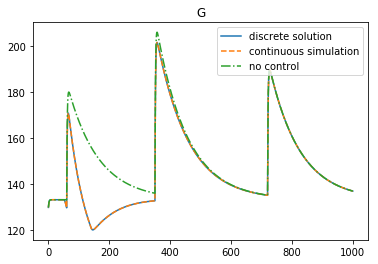

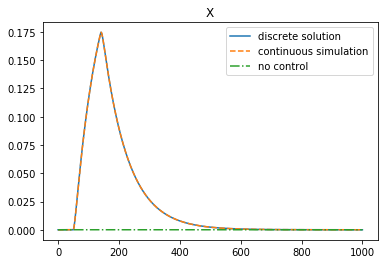

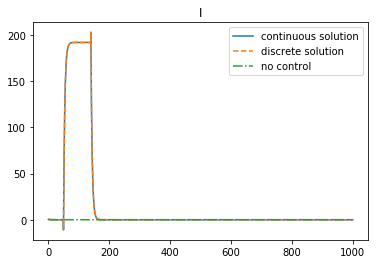

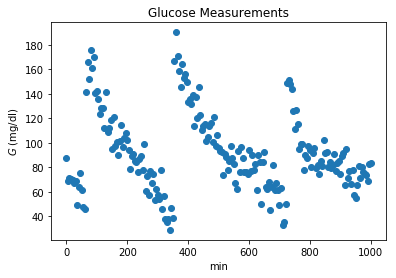

In [24]:
# %load main
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: The main function to run the model

#from Initialization import tk_list, qk_list, tau, t_list, c1, c2, dt, I0, meas_time, p1, p2, p3, Gb, Ib, G0,X0, Ra_0, h, lam, end_time
#import Plot, Glucose
#import numpy as np
#import Simulation, Measurement
#import matplotlib.pyplot as plt
#import Cost
#import Insulin_ODE_Solver
##Some test


## Some simple control on insulin injection; later will be replaced by control from SGD
vn_list = np.zeros([1, len(t_list)])[0]
#print("No control *****************************************************")
G_no_c, X_no_c, I_no_c =  path_generator(vn_list, p1, p2, p3, Gb, Ib, I0, c1, c2, meas_time, t_list, tk_list, qk_list, tau, G0,X0, Ra_0, dt, h)
vn_list[100:280] = 240
#vn_list[70:80] = 20
#vn_list[160:170] = 20


G_list, X_list, I_from_DOE_solver = path_generator(vn_list, p1, p2, p3, Gb, Ib, I0, c1, c2, meas_time, t_list, tk_list, qk_list, tau, G0,X0, Ra_0, dt, h)
I_list = insulin_solver(I0, t_list, vn_list, c1, c2)
print("cost:", cost_computation(G_list, Gb, lam, vn_list, end_time))
G,X,I = cont_path_generator(vn_list, p1, p2, p3, Gb, Ib, I0, c1, c2, t_list, tk_list, qk_list, tau, G0, X0, Ra_0)

plt.plot(t_list , G_list, label="discrete  simulation")
plt.plot(t_list, G,  '--',   label="continuous simulation")
plt.plot(t_list, G_no_c, '-.',label="no control")

plt.title("G")
plt.legend()
plt.show()

plt.plot(t_list , X_list, label="discrete simulation")
plt.plot(t_list, X,  '--',   label="continuous simulation")
plt.plot(t_list, X_no_c, '-.',label="no control")

plt.title("X")
plt.legend()
plt.show()



plt.plot(t_list,I, label = "continuous  simulation")
plt.plot(t_list,I_list,'--',label ="discrete solution")
plt.plot(t_list,I_no_c,'-.', label ="no control")

plt.title("I")
plt.legend()
plt.show()
noisy_meas = measurement_generation( t_list, tk_list, qk_list, dt)
Plot_measurement(noisy_meas, t_list, dt)

### Comparison Between Theoretical Solution and ODE package Solution

$R_a(t)$ and $I(t)$ both have theoretical solutions with Laplace transform. 
<li> In the program, we will use the theoretical solution of $R_a(t)$, because it numerical solution is not very accurate. $R_a(t)$ involves an approximation of delta function, which add a lot of uncertainty to the ODE solver.
I approximate Dirac Delta function using the a Gaussian distribution, by setting the covariance ($a$ in code) small.
However, if $a$ is too small, when applying numpy ODE solver, it sometimes will miss the peak. Thus we perfer theoretical solution here.
<li> The theoreical and numerical solutions of $I(t)$ are very close. We choose to use numerical solution here since it is more efficient.

In [25]:
# %load Glucose_ODE_solver
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: This program contains parameters and functions to determine Ra(t) using numpy ODE solver
"""this page is not used in the program except for comparision to verify theoretical solution"""

from scipy.integrate import odeint
import numpy as  np

def D(t, tk_list, qk_list):
    """meal distrubance model: D(mg/kg/min)
    @:param t:          time
    @:param tk_list:    a list of time t when the meal intake happens
    @:param qk_list:    a list of input value q representing the input glucose level
                        ( len(qk_list)=len(tk_list) ) """
    D_t = 0
    for i in range(len(tk_list)):
        D_t += DiracDelta(t, tk_list[i])*qk_list[i]

    #debug...print(t, D_t)
    return D_t

def DiracDelta(t,q):
    """Dirac Delta function as the limit of normal distributions as a goes to 0
    @:param t: time
    @:param q: the peak point"""

    a = 1.3    #notice: though a should be as small as possible to represent a Dirac Delta function
               #however, if a is too small, it will cause difficulty to for ODE solver, it may miss some peaks
    return  1/(a*np.sqrt(np.pi))*np.exp(-((t-q)/a)**2)


def dRadt(x, t, tau, tk_list, qk_list):
    """ ODE for insulin dynamics model
    @:param x:          [I]
    @:param t:          time
    @:param tau:        a constant parameter associated with digestion efficiency
    @:param tk_list:    a list of time t when the meal intake happens
    @:param qk_list:    a list of input value q representing the input glucose level
                        ( len(qk_list)=len(tk_list) ) """

    Ra = x[0]
    dRa_dt = -1/tau * (Ra - D(t, tk_list, qk_list))

    return [dRa_dt]


def glucose_solver(t_list,  tau, tk_list, qk_list, Ra_0):
    """ ODE solver for glucose disappearance rate Ra(t)
    @:param t_list:     time discretization for the simulation
    @:param tau:        a constant parameter associated with digestion efficiency
    @:param tk_list:    a list of time t when the meal intake happens
    @:param qk_list:    a list of input value q representing the input glucose level
    @:param Ra_0:       initial condition of Ra(t)"""

    ## initial condition for [G, X]
    x0 = [Ra_0]

    ## Solve ODE system
    x  = odeint(dRadt, x0, t_list, args=(tau, tk_list, qk_list))

    ## return the result
    Ra = x[:,0]

    return Ra



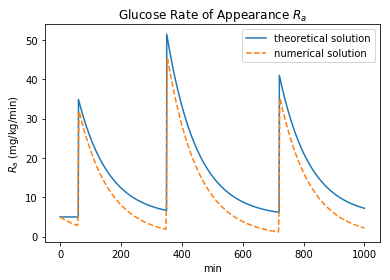

In [26]:
test_Ra(t_list, tau, tk_list, qk_list, Ra_0)

In [18]:
# %load Insulin
# Author: Xinyu Li
# Email: xl1796@nyu.edu
# Date: August 2019
# Description: This program contains parameters and functions to determine I(t) theoretically
"""this page has been given up"""
import numpy as np

def find_tn(tn_list, dt, t):
    """given a list of time descritization and time t, find out tn such that
    tn < t <= t_{n+1}"""
    tn = tn_list[int(t//dt)]
    if t%dt != 0 or t==0:
        return tn
    return tn-dt


def inner_I(t, In, vn, c1, c2, meas_time, dt):
    """inner_I(t) is the insulin function at (tn, tn + delta t),
       a theoretical solution of insulin ODE give I(tn)
    @:param t:         time
    @:param In:        initial condition for I(t) at (tn, tn + delta t)
    @:param vn:        a constant control exerted on insulin
    @:param c1:        constant parameter in the insulin ODE model
    @:param c2:        constant parameter in the insulin ODE model
    @:param meas_time: time when measurements happen
    @:param dt:        time interval between 2 measurements
    @:return           the value of I at time t"""

    ## Find the previous state time tn
    tn  = find_tn(meas_time, dt, t)
    ## Find I(t) for t in (tn, tn+dt)
    I_t = c2*vn/c1*(1-np.exp(-c1*(t-tn)))+In*np.exp(-c1*(t-tn))
    return I_t


def vn_conversion(vn_list, dt, h):
    """because the number of control should be the number of measurement-1, but
    sometimes we need number of control to be same as the number of time steps.
    This function convert vn_list from len(meas_time) to len(t_list)"""

    step = int(dt//h)
    v = np.reshape(vn_list, [len(vn_list), 1, 1])
    b = np.ones([len(vn_list),step , 1])
    c = b@v
    new_vn_list = np.reshape(c, [1, step*len(vn_list)])
    return new_vn_list[0]


def find_I_list(t_list, vn_list, I0, c1, c2, meas_time, dt):
    """a function find out I(t) at any given time t
    @:param t_list:    time discretization
    @:param vn_list:   a list of control
    @:param I0:        initial value of Insulin
    @:param c1:        insulin coefficient
    @:param c2:        insulin coefficient
    @:param meas_time: time when measurements happens
    @:param dt:        time interval between two measurements happens"""

    I_list  = []
    In      = I0
    for i in range(len(t_list)):
        t_  = t_list[i]
        vn  = vn_list[i]
        I_t = inner_I(t_, In, vn, c1, c2, meas_time, dt)
        I_list.append(I_t)
        if t_ % dt == 0:
            In = I_t
    return I_list

def Linear_func(t, I_list, t_list):
    """ Find out I at time t using a linear approximation between two points in t_list
    @:param t:         given time
    @:param I_list:    a list of insulin values with respect to t
    @:param t_list:    the corresponding time discretization """

    idx1 = int(t//(t_list[1] - t_list[0]))
    idx2 = idx1+1

    if idx2<len(I_list):
        y1   = I_list[idx1]
        y2   = I_list[idx2]
        x1   = t_list[idx1]
        x2   = t_list[idx2]
        I_t  = (y2-y1)/(x2-x1)*(t-x1)+y1
        return I_t
    return I_list[-1]


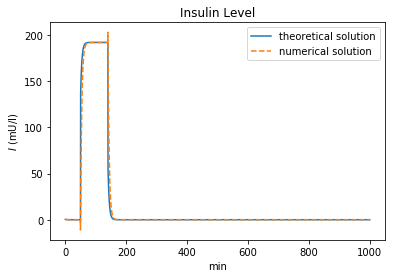

In [20]:
test_I(vn_list, I0, t_list, c1, c2, meas_time, dt)